## 仓位管理-multi_signal_add_position

### 一、多信号加仓法

## 1.多信号加仓法

 满足信号的个数越多，加仓越多。
 
 见 onBar ‘多信号加仓模块’以及on15Bar‘信号计算与开仓逻辑’
 
用参数 n 控制加仓次数，参数fixsize为开仓手数以及每次加仓数量

### 开仓算法如下：

计算3个指标分别为MACD,RSI,movement并计算信号值signal_1,signal_2,signal_3和signal. signal = signal_1+signal_2+signal_3

if not 空头信号 and signal == 1:

    buy
    
elif not 多头信号 and signal == -1:

    short
    
### 加仓算法如下：

if 持多头仓位 and 当前加仓次数 nPos < 2：

    if 出现空头信号：
    
        sell 全部多头头寸
        
    elif 没加过仓 and signal == 2:
    
        加仓fixsize手
        
    elif 加过一次仓 and signal == 3:
    
        加仓fixsize手
    
elif 持空头仓位 and 当前加仓次数 nPos < 2：

    if 出现多头信号：
    
        cover 全部空头头寸
        
    elif 没加过仓 and signal == -2:
    
        加仓fixsize手
        
    elif 加过一次仓 and signal == -3:
    
        加仓fixsize手
        

### 当执行平仓信号，将 nPos 重置为 0 

if 持有多头仓位 and 死叉：

    nPos = 0
    
elif 持有空头仓位 and 金叉：

    nPos = 0

In [ ]:
# 设置参数
    nPos = 0
    fixsize = 100
    transactionPrice = {}
    Ratio = 0.02
    signal_1 = 0
    signal_2 = 0
    signal_3 = 0
    signal = 0
    
# 设置变量    
    self.transactionPrice = {s: 0 for s in self.symbolList}
    
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
                
        # 多信号加仓模块，多空相反______________________________________
        if (self.posDict[symbol+'_LONG']!=0 and self.nPos < 2):    # 持有多头仓位并且加仓次数不超过2次(共三个信号，允许加2次仓)
            if self.signal_1 < 0 or self.signal_2 < 0 or self.signal_3 < 0:   # 持有多仓情况下有一个信号转换为空头信号，则清仓出场
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG']) # 全部头寸出场
            elif self.nPos == 0 and self.signal == 2 :   # 第一次开仓是有一个信号满足，当另一个信号满足多头信号，则加仓
                self.nPos += 1  # 加仓次数减少 1 次
                self.buy(symbol,bar.close*1.02,self.fixsize)  # 加仓数量固定fixsize
            elif self.nPos == 1 and self.signal == 3 :   # 建立在第一次加仓的基础上，再有信号满足多头信号，继续加仓
                self.buy(symbol,bar.close*1.02,self.fixsize)  # 加仓数量固定fixsize
                
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.nPos < 2):    
            if self.signal_1 > 0 or self.signal_2 > 0 or self.signal_3 > 0:   #
                    self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT']) 
            elif self.nPos == 0 and self.signal == -2 :   # 计算盈利比例
                self.nPos += 1  # 加仓次数减少 1 次
                self.short(symbol,bar.close*0.98,self.fixsize)  # 加仓数量固定fixsize
            elif self.nPos == 1 and self.signal == -3 :
                self.short(symbol,bar.close*0.98,self.fixsize)  # 加仓数量固定fixsize
                
        # 发出状态更新事件
        self.putEvent()
        
    def on15MinBar(self, bar):
        """30分钟K线推送"""
        symbol = bar.vtSymbol
    
        am15 = self.getArrayManager(symbol, "15m")

        if not am15.inited:
            return
        
        # 计算策略需要的信号，共三个信号分别是MACD,rsi,动量指标-------------------------------------------------
        diff,dea,hist = ta.MACD(am15.close)
        
        if diff[-1]<0 and dea[-1]<0 and diff[-2]<dea[-2] and diff[-1]>dea[-1]:  
            self.signal_1 = 1
        elif diff[-1]>0 and dea[-2]>0 and diff[-2]>dea[-2] and diff[-1]<dea[-1]:
            self.signal_1 = -1
        else:
            self.signal_1 = 0
        
        rsi = ta.RSI(am15.close)
        
        if rsi[-2]<38 and rsi[-1]>38:
            self.signal_2 = 1
        elif rsi[-2]>68 and rsi[-1]<68:
            self.signal_2 = -1
        else:
            self.signal_2 = 0    
        
        movement = (am15.close[-1] - am15.close[-10])/am15.close[-10]
        
        if movement < -0.015:
            self.signal_3 = 1
        elif movement > 0.015:
            self.signal_3 = -1
        else:
            self.signal_3 = 0
        ###    将三个信号加和
        self.signal = self.signal_1 + self.signal_2 + self.signal_3
        
        # 构建进出场逻辑-------------------------------------------------
        # 如果3个都不是空头信号，并且有一个信号满足多头信号，则开多仓
        if self.signal_1 >= 0 and self.signal_2 >= 0 and self.signal_3 >= 0 and self.signal == 1:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.02, self.fixsize*0.3)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] >0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
                self.nPos = 0
                self.buy(symbol,bar.close*1.02, self.fixsize*0.3)

        # 如果3个都不是多头信号，并且有一个信号满足空头信号，则开空仓
        elif self.signal_1 <= 0 and self.signal_2 <= 0 and self.signal_3 <= 0 and self.signal == -1:
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
            elif self.posDict[symbol+'_LONG'] >0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                self.nPos = 0
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
        
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------

### 多信号加仓法案例，可以自行更改进出场信号signal_1、signal_2、signal_3

In [2]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import CtaTemplate
import numpy as np
import talib as ta
from datetime import timedelta

########################################################################
# 策略继承CtaTemplate
class multi_signal_Strategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'multi_signal_Strategy'
    author = 'ChannelCMT'
    
    # 策略参数
    barPeriod = 200
    fastWindow = 60     # 快速均线参数
    slowWindow = 120     # 慢速均线参数
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'fastWindow',
                 'slowWindow']    
    
    # 变量列表，保存了变量的名称
    varList = ['barPeriod']  
    nPos = 0
    fixsize = 100
    transactionPrice = {}
    Ratio = 0.02
    signal_1 = 0
    signal_2 = 0
    signal_3 = 0
    signal = 0
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        
        # 生成Bar数组
        self.setArrayManagerSize(self.barPeriod)
        self.transactionPrice = {s: 0 for s in self.symbolList}


        self.mail("chushihuaaaaaaaaaaaaaaaaaaaaaaaaa")
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
                
        # 多信号加仓模块，多空相反______________________________________
        if (self.posDict[symbol+'_LONG']!=0 and self.nPos < 2):    # 持有多头仓位并且加仓次数不超过2次(共三个信号，允许加2次仓)
            if self.signal_1 < 0 or self.signal_2 < 0 or self.signal_3 < 0:   # 持有多仓情况下有一个信号转换为空头信号，则清仓出场
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG']) # 全部头寸出场
            elif self.nPos == 0 and self.signal == 2 :   # 第一次开仓是有一个信号满足，当另一个信号满足多头信号，则加仓
                self.nPos += 1  # 加仓次数减少 1 次
                self.buy(symbol,bar.close*1.02,self.fixsize)  # 加仓数量固定fixsize
            elif self.nPos == 1 and self.signal == 3 :   # 建立在第一次加仓的基础上，再有信号满足多头信号，继续加仓
                self.buy(symbol,bar.close*1.02,self.fixsize)  # 加仓数量固定fixsize
                
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.nPos < 2):    
            if self.signal_1 > 0 or self.signal_2 > 0 or self.signal_3 > 0:   #
                    self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT']) 
            elif self.nPos == 0 and self.signal == -2 :   # 计算盈利比例
                self.nPos += 1  # 加仓次数减少 1 次
                self.short(symbol,bar.close*0.98,self.fixsize)  # 加仓数量固定fixsize
            elif self.nPos == 1 and self.signal == -3 :
                self.short(symbol,bar.close*0.98,self.fixsize)  # 加仓数量固定fixsize
                
        # 发出状态更新事件
        self.putEvent()
        
    def on15MinBar(self, bar):
        """30分钟K线推送"""
        symbol = bar.vtSymbol
    
        am15 = self.getArrayManager(symbol, "15m")

        if not am15.inited:
            return
        
        # 计算策略需要的信号，共三个信号分别是MACD,rsi,动量指标-------------------------------------------------
        diff,dea,hist = ta.MACD(am15.close)
        
        if diff[-1]<0 and dea[-1]<0 and diff[-2]<dea[-2] and diff[-1]>dea[-1]:  
            self.signal_1 = 1
        elif diff[-1]>0 and dea[-2]>0 and diff[-2]>dea[-2] and diff[-1]<dea[-1]:
            self.signal_1 = -1
        else:
            self.signal_1 = 0
        
        rsi = ta.RSI(am15.close)
        
        if rsi[-2]<38 and rsi[-1]>38:
            self.signal_2 = 1
        elif rsi[-2]>68 and rsi[-1]<68:
            self.signal_2 = -1
        else:
            self.signal_2 = 0    
        
        movement = (am15.close[-1] - am15.close[-10])/am15.close[-10]
        
        if movement < -0.015:
            self.signal_3 = 1
        elif movement > 0.015:
            self.signal_3 = -1
        else:
            self.signal_3 = 0
        ###    将三个信号加和
        self.signal = self.signal_1 + self.signal_2 + self.signal_3
        
        # 构建进出场逻辑-------------------------------------------------
        # 如果3个都不是空头信号，并且有一个信号满足多头信号，则开多仓
        if self.signal_1 >= 0 and self.signal_2 >= 0 and self.signal_3 >= 0 and self.signal == 1:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.02, self.fixsize*0.3)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] >0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
                self.nPos = 0
                self.buy(symbol,bar.close*1.02, self.fixsize*0.3)

        # 如果3个都不是多头信号，并且有一个信号满足空头信号，则开空仓
        elif self.signal_1 <= 0 and self.signal_2 <= 0 and self.signal_3 <= 0 and self.signal == -1:
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
            elif self.posDict[symbol+'_LONG'] >0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                self.nPos = 0
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
        
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         print(u'出现未知订单，需要策略师外部干预,ID:%s, symbol:%s,direction:%s,offset:%s'% (order.vtOrderID, order.vtSymbol, order.direction, order.offset))
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        self.transactionPrice[symbol] = trade.price
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

## 绩效测试

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function multi_signal_Strategy.onBar at 0x0000019A88876488>, <__main__.multi_signal_Strategy object at 0x0000019A88922BA8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function multi_signal_Strategy.on15MinBar at 0x0000019A88876510>, <__main__.multi_signal_Strategy object at 0x0000019A88922BA8>)
2018-11-15 22:42:48.144801	开始回测
2018-11-15 22:42:48.144801	策略初始化
2018-11-15 22:42:48.147796	载入历史数据。数据范围:[20180923 04:00,20181001 12:00)
2018-11-15 22:43:21.129696	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-15 22:43:21.142658	载入完成，数据量：12000
2018-11-15 22:43:21.144660	策略初始化完成
2018-11-15 22:43:21.144660	策略启动完成
2018-11-15 22:43:21.144660	开始回放回测数据,回测范围:[20181001 12:00,20181031 16:00)
2018-11-15 22:43:21.157650	载入历史数据。数据范围:[20181001 12:00,20181031 16:00)
2018-11-15 22:43:59.210790	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-15 22:43:59.252723	载入完成，数据量：43230
2

D:\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.13.dev181104-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py:1287: RuntimeWarning: invalid value encountered in log
  df['return'] = (np.log(df['balance']) - np.log(df['balance'].shift(1))).fillna(0)


2018-11-15 22:45:14.410675	策略回测绩效图已保存


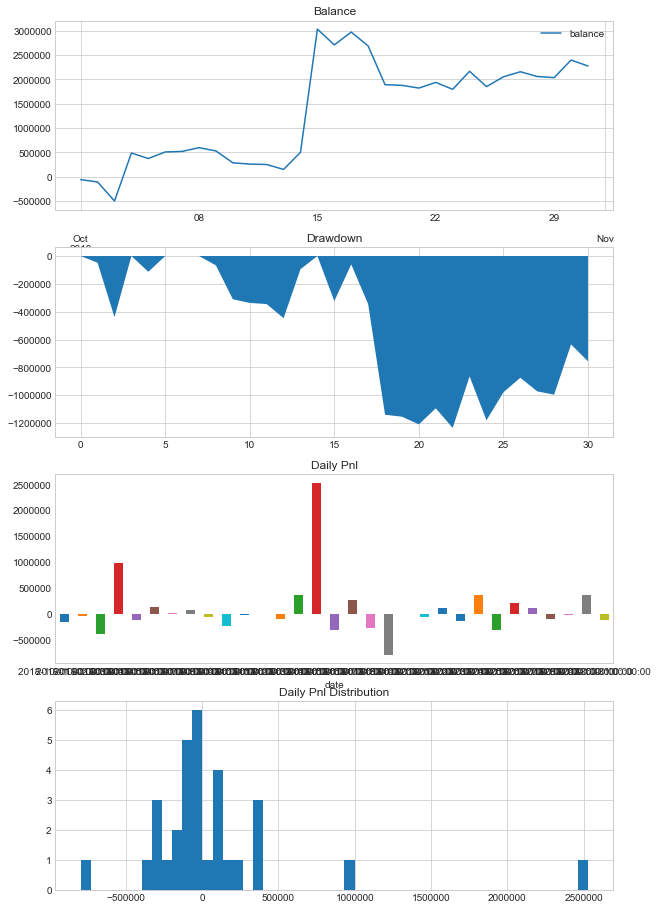

2018-11-15 22:45:15.192194	计算回测结果
2018-11-15 22:45:15.222174	交割单已生成
2018-11-15 22:45:15.223172	------------------------------
2018-11-15 22:45:15.223172	第一笔交易：	2018-10-01 16:15:00
2018-11-15 22:45:15.223172	最后一笔交易：	2018-10-31 15:58:00
2018-11-15 22:45:15.223172	总交易次数：	180
2018-11-15 22:45:15.223172	总盈亏：	284,654.44
2018-11-15 22:45:15.223172	最大回撤: 	-6,423,167.65
2018-11-15 22:45:15.223172	平均每笔盈利：	1,581.41
2018-11-15 22:45:15.223172	平均每笔滑点：	0.0
2018-11-15 22:45:15.223172	平均每笔佣金：	21,644.75
2018-11-15 22:45:15.223172	胜率		45.56%
2018-11-15 22:45:15.224172	盈利交易平均值	203,081.68
2018-11-15 22:45:15.224172	亏损交易平均值	-167,020.85
2018-11-15 22:45:15.224172	盈亏比：	1.22
2018-11-15 22:45:16.140242	策略回测统计图已保存


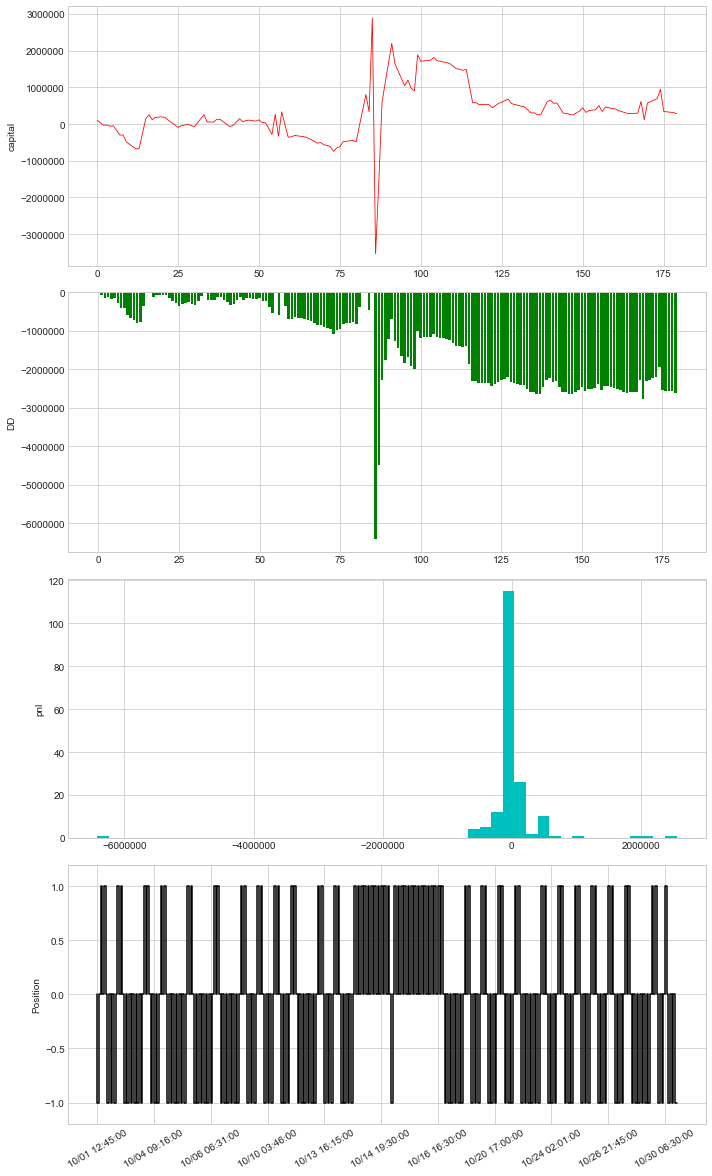

2018-11-15 22:45:16.877789	计算按日统计结果


In [4]:
from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)
    engine.setDatabase('VnTrader_1Min_Db')
    engine.setStartDate(startDate, initHours=200)
    engine.setEndDate(endDate)
    engine.setSize(size)
    engine.setSlippage(slippage)
    engine.setRate(rate)
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)
    engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(multi_signal_Strategy, {'symbolList': ['BTCUSDT:binance']},
                       '20181001 12:00', '20181031 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('BBandMa5MinStrategyReport.xlsx')

## 绩效报告

In [3]:
tradeReport

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-10-01 22:30:00,空,,,0.0,,开仓,1,,6556.00,0.0,None,,,1,2018-10-01 22:30:00,30.0,1,BTCUSDT:binance,1
2018-10-04 22:30:00,多,,,0.0,,平仓,2,,6586.00,0.0,None,,,2,2018-10-04 22:30:00,30.0,2,BTCUSDT:binance,2
2018-10-04 22:30:00,多,,,0.0,,开仓,3,,6586.00,0.0,None,,,3,2018-10-04 22:30:00,30.0,3,BTCUSDT:binance,3
2018-10-10 16:30:00,空,,,0.0,,平仓,4,,6567.03,0.0,None,,,4,2018-10-10 16:30:00,30.0,4,BTCUSDT:binance,4
2018-10-10 16:30:00,空,,,0.0,,开仓,5,,6567.03,0.0,None,,,5,2018-10-10 16:30:00,30.0,5,BTCUSDT:binance,5
2018-10-11 08:00:00,多,,,0.0,,平仓,6,,6630.21,0.0,None,,,6,2018-10-11 08:00:00,30.0,6,BTCUSDT:binance,6
2018-10-11 08:00:00,多,,,0.0,,开仓,7,,6630.21,0.0,None,,,7,2018-10-11 08:00:00,30.0,7,BTCUSDT:binance,7
2018-10-11 08:30:00,空,,,0.0,,平仓,8,,6586.65,0.0,None,,,8,2018-10-11 08:30:00,30.0,8,BTCUSDT:binance,8
2018-10-11 08:30:00,空,,,0.0,,开仓,9,,6586.65,0.0,None,,,9,2018-10-11 08:30:00,30.0,9,BTCUSDT:binance,9
